# State manifolds in a single condition / recording

Before moving to a full-on implementation and comparison, let's implement and test the necessary analyses and check what can be achieved. In this notebook, we apply the different metrics to a sub-set of the baseline condition. 

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath("/home/neurobook/Desktop/Research/_dev/conic-tools/") 
sys.path.insert(0, module_path)
module_path = os.path.abspath("/home/neurobook/Desktop/Research/_dev/PySpike/") 
sys.path.insert(0, module_path)

In [2]:
import numpy as np
from scipy.io import loadmat

from conic_tools.analysis.signals import SpikeList, StateMatrix

### Looking at raw activity

To begin with, let's load the data and plot the raw spiking activity. In this example analysis, we will use a small sub-sample (first 5 seconds of recorded activity) and start by looking at a raster plot:

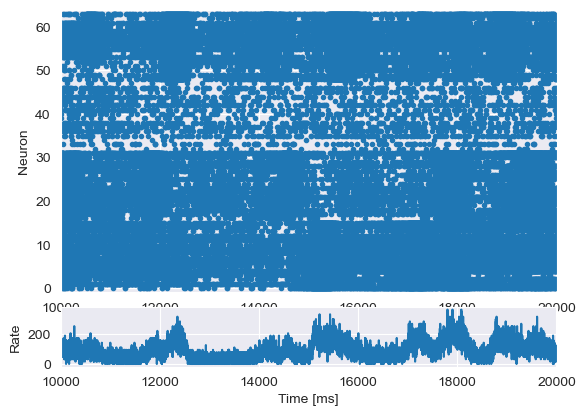

In [3]:
data = loadmat('/home/neurobook/Desktop/Research/MEA-data/data/n1-DIV17-01.mat')
ids = data['Channels'][0]
times = data['Times'][0]

spk_times = [(i, times[idx]*1000) for idx, i in enumerate(ids)]
spk_ids = np.unique(ids)

sl_n1 = SpikeList(spk_times, spk_ids)
sl_n1_small = sl_n1.time_slice(10000., 20000.)
sl_n1_small.raster_plot(with_rate=True)

For the state analysis, the first requirement is that we need a 'smooth' signal. Typically performed at the level of instantaneous firing rates or calcium traces or other smooth continuous variables, we need to first pre-process the raw spiking data. This can be achieved in multiple ways: the most common are a Gaussian or exponential filter. A Gaussian filter is, in my opinion, unsuitable for spiking data, as it breaks temporal causality. It may not matter for most analyses, but it does not reflect the actual activity. So, I will apply a simple (exponential) low-pass filter to the spikes.


Compiling activity matrix from SpikeList


100%|██████████| 64/64 [01:59<00:00,  1.87s/it]


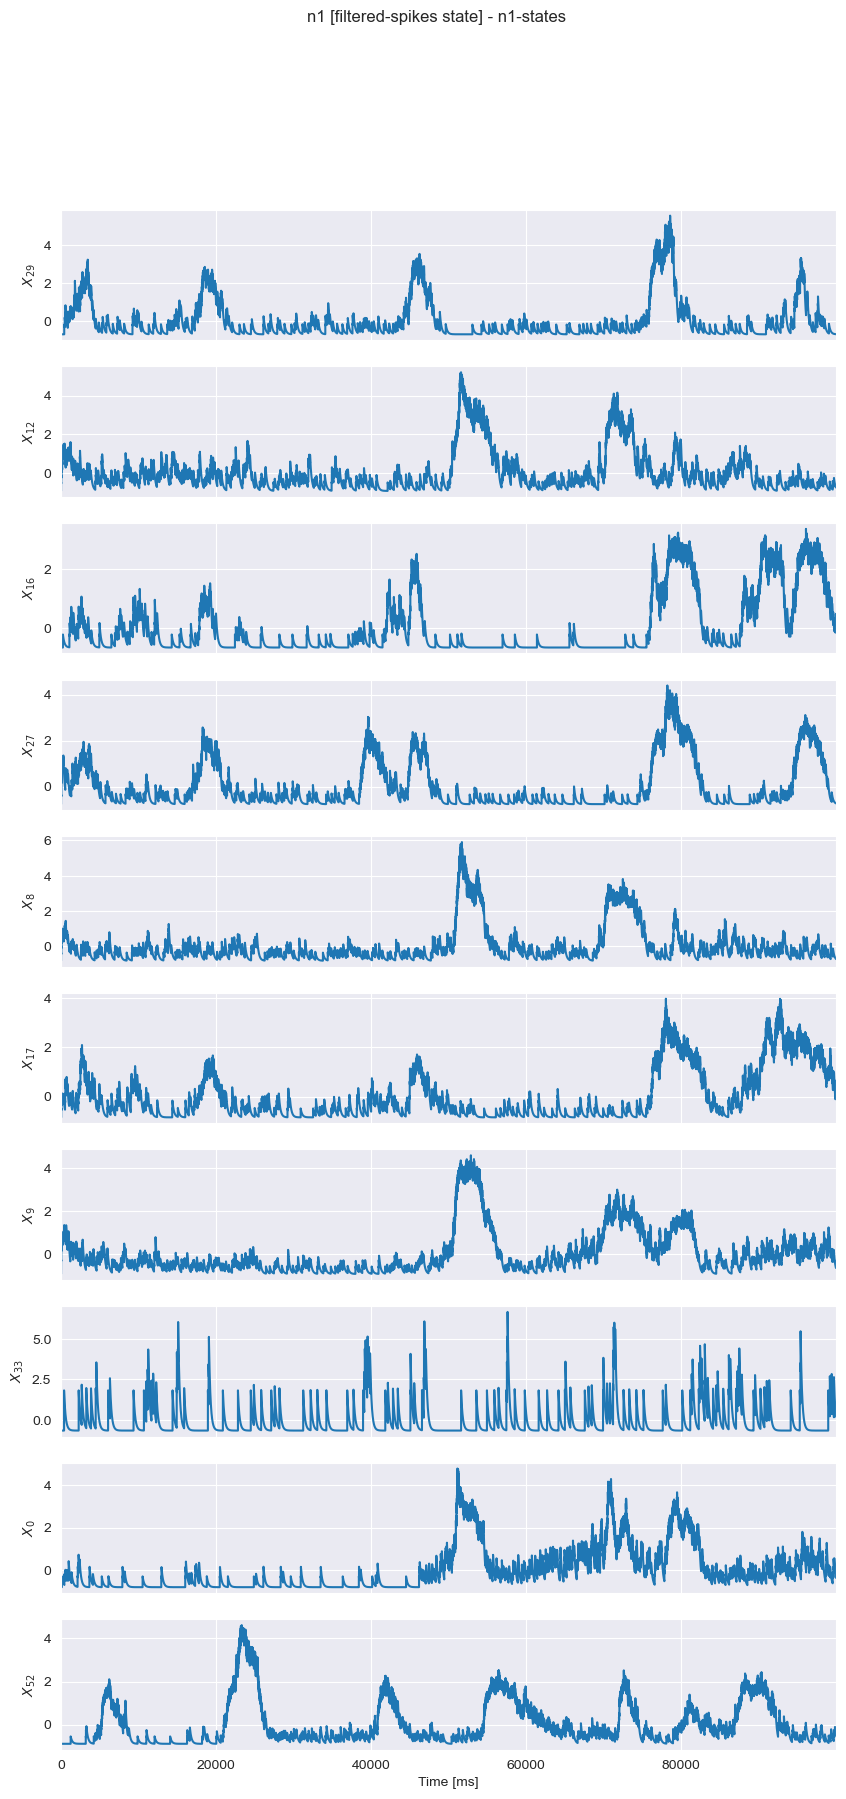

In [4]:
states = sl_n1_small.filter_spiketrains(dt=0.1, tau=20.)
sm_n1_small = StateMatrix(states, label="n1-states", state_var="filtered-spikes", population="n1", standardize=True)
sm_n1_small.plot_sample_traces(save='./plots/sample_traces11.png')

In [5]:
states_n1 = sl_n1.filter_spiketrains(dt=0.1, tau=20.)
sm_n1 = StateMatrix(states_n1, label="n1-states", state_var="filtered-spikes", population="n1", standardize=False)


Compiling activity matrix from SpikeList


100%|██████████| 64/64 [41:19<00:00, 38.74s/it]


Note that we make a relatively arbitrary choice of an important parameter ($\tau=20\mathrm{ms}$) which will impact the results. This value is frequently used as a proxy for the timescale of instantaneous postsynaptic integration, i.e., the exponential low-pass filter is aimed to mirror what a postsynaptic neuron would 'see'. But let's keep in mind that this may impact the results. 

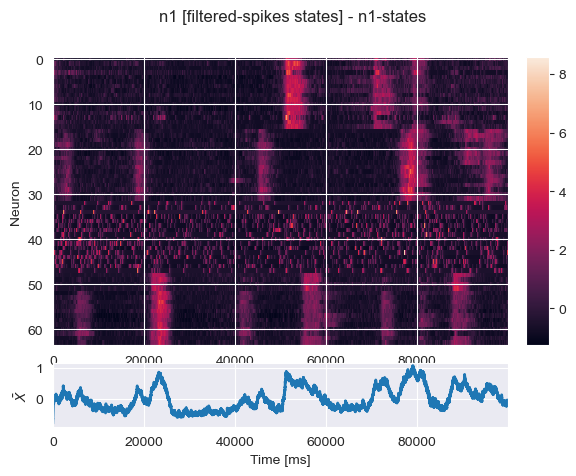

In [6]:
sm_n1_small.plot_matrix(save='./plots/sample-states1.png')

Now, let's begin the state-space analysis where we look at the organization of population states across time and conditions.
For this preliminary analysis, we will look at a single dataset.

---

### Pair-wise distances and state complexity



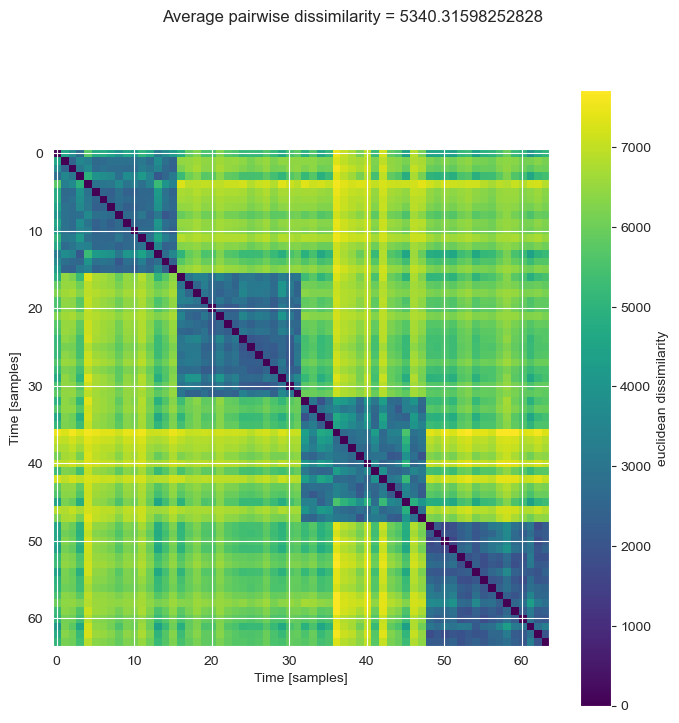

array([[   0.        , 4508.81031755, 3713.89400661, ..., 4023.13328613,
        4714.30835858, 5038.68389183],
       [4508.81031755,    0.        , 2512.54099423, ..., 6125.58247862,
        6310.60042964, 6130.93808351],
       [3713.89400661, 2512.54099423,    0.        , ..., 5784.96456079,
        6082.34920321, 6032.686149  ],
       ...,
       [4023.13328613, 6125.58247862, 5784.96456079, ...,    0.        ,
        2833.87599095, 3289.85221931],
       [4714.30835858, 6310.60042964, 6082.34920321, ..., 2833.87599095,
           0.        , 1991.54183747],
       [5038.68389183, 6130.93808351, 6032.686149  , ..., 3289.85221931,
        1991.54183747,    0.        ]])

In [7]:
from auxiliary import pairwise_distances

pairwise_distances(states_n1, metric='euclidean', plot=True, display=True, save='./plots/Euc_dist_n1.png')

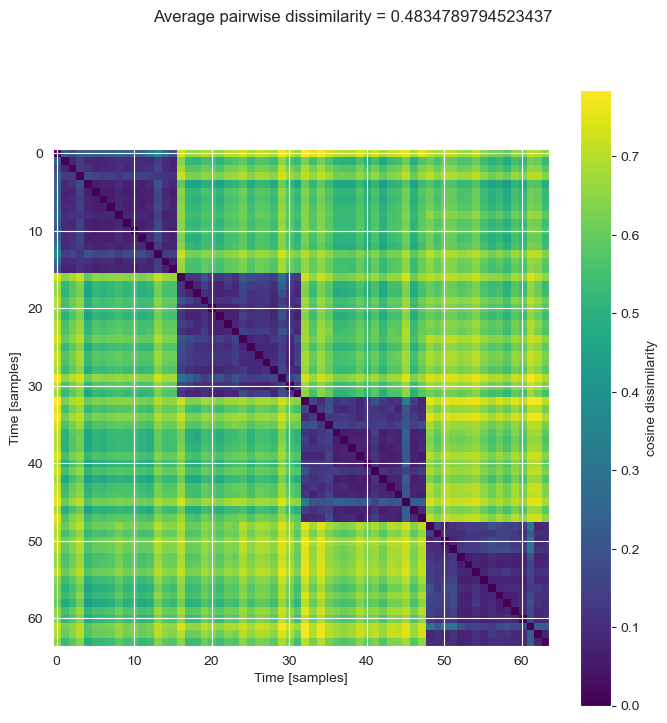

array([[0.        , 0.22906881, 0.17158259, ..., 0.7067958 , 0.69210986,
        0.64570123],
       [0.22906881, 0.        , 0.07602506, ..., 0.61614725, 0.60226533,
        0.52772985],
       [0.17158259, 0.07602506, 0.        , ..., 0.65659078, 0.64531994,
        0.58024986],
       ...,
       [0.7067958 , 0.61614725, 0.65659078, ..., 0.        , 0.22420139,
        0.22522312],
       [0.69210986, 0.60226533, 0.64531994, ..., 0.22420139, 0.        ,
        0.07752669],
       [0.64570123, 0.52772985, 0.58024986, ..., 0.22522312, 0.07752669,
        0.        ]])

In [8]:
pairwise_distances(states_n1, metric='cosine', plot=True, display=True, save='./plots/cosine_dist_n1.png')

### State trajectories, dimensionality and density

Let's first look at a sample trajectory, embedded in a low-dimensional space, using PCA (the simplest and most straightforward dimensionality reduction method):

[states.py:322 - INFO] Explained Variance (first 3 components): [0.24399041 0.19945798 0.16924035]
[states.py:44 - INFO] Determining effective dimensionality...
[states.py:57 - INFO] Effective dimensionality = 7.49
[states.py:58 - INFO] Elapsed Time: 0.001 s


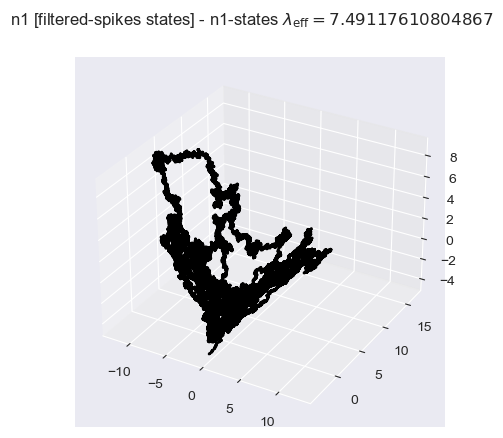

In [9]:
sm_n1_small.plot_trajectory(save='./plots/sample_trajectory.png')

[states.py:322 - INFO] Explained Variance (first 3 components): [0.24459686 0.23313667 0.19160665]
[states.py:44 - INFO] Determining effective dimensionality...
[states.py:57 - INFO] Effective dimensionality = 5.53
[states.py:58 - INFO] Elapsed Time: 0.002 s


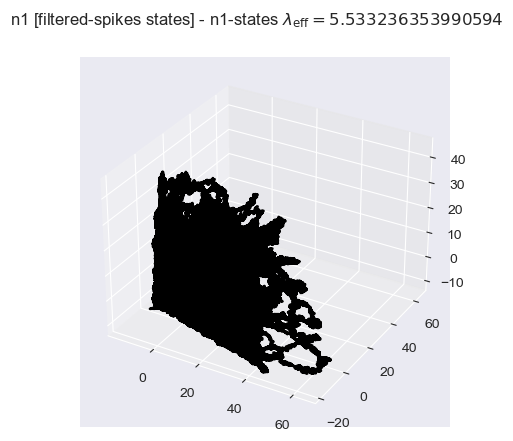

In [10]:
sm_n1.plot_trajectory(save='./plots/full_trajectory.png')

As already depicted above, we can determine the systems' dynamics *effective dimensionality* ($\lambda_{\mathrm{eff}$) based on the variance explained by the different PCs.

This metric tells us the dimensionality of the subspace where activity predominantly lies. We will see later other ways to compute this (and compare the results).

[states.py:164 - INFO] Determining effective dimensionality of states n1-states
[states.py:177 - INFO] - Effective dimensionality = 7.49
[states.py:178 - INFO] - Elapsed Time: 0.394 s


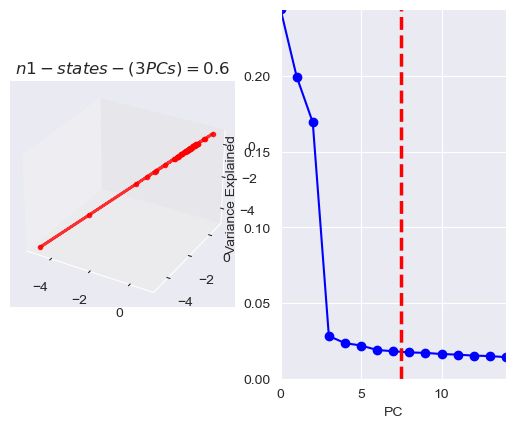

7.49117610804867

In [11]:
sm_n1_small.effective_dimensionality()

We can also quickly check if, within the trajectory, there are regions of state-space where the network stays for longer periods of time. We use 2D kernel-density estimation (with a Gaussian kernel) to obtain estimates of state density:

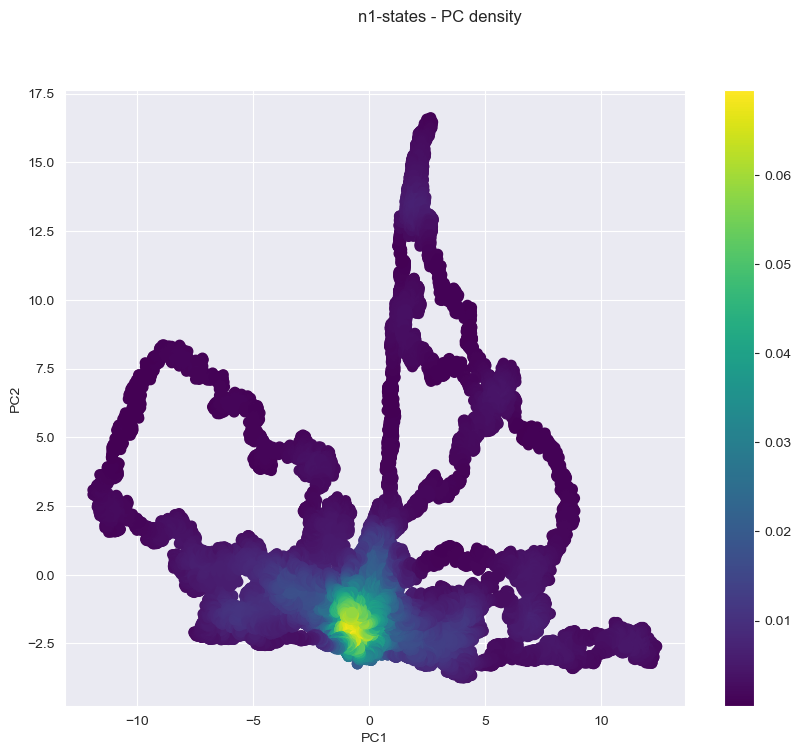

In [12]:
sm_n1_small.state_density(save='./plots/state_density_small.png')


In [ ]:
sm_n1.state_density(save='./plots/state_density.png')

--- 
The following methods haven't been integrated in the tools yet... Have been adapted from [Schultz-Lab](https://github.com/schultzlab/Neural_Manifolds/)


In [9]:
import sys, os, time
import numpy as np
import scipy.io as io
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE
from sklearn.model_selection import KFold
import sklearn.metrics.pairwise as mtr
import umap

import NMLfunc as nml

import warnings
warnings.filterwarnings("ignore")

### Pairwise distances
A good way to start is to look at pairwise distances between the states of single neurons. This can also be used as a measure of complexity of network dynamics.

In [10]:
# obtain cosine distance matrix
down = 10 # downsampling factor for speeding up calculations (and memory constraints)
X = sm_n1_small.matrix[:,::down].T
D = cosine_distances(X)

In [11]:
D.mean()

0.27969611028760344

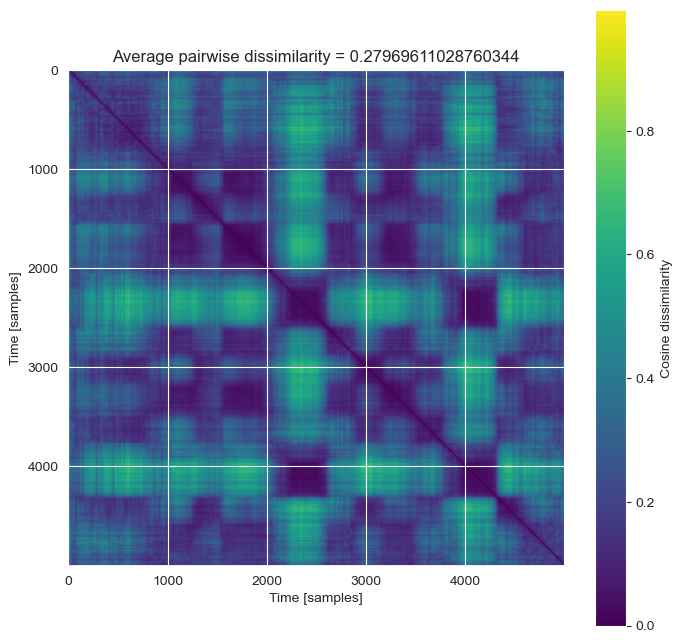

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(D,cmap='viridis'); cbar = plt.colorbar(); cbar.set_label('Cosine dissimilarity')
plt.xlabel('Time [samples]'); plt.ylabel('Time [samples]');
plt.title("Average pairwise dissimilarity = {}".format(D.mean()));

In [13]:
# obtain Euclidean distance matrix
X = sm_n1_small.matrix[:,::down].T
D = euclidean_distances(X)

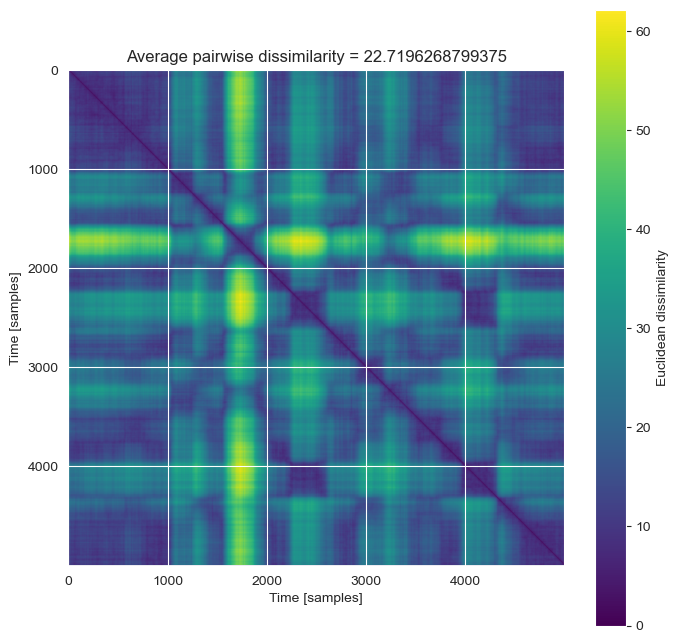

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(D,cmap='viridis'); cbar = plt.colorbar(); cbar.set_label('Euclidean dissimilarity')
plt.xlabel('Time [samples]'); plt.ylabel('Time [samples]');
plt.title("Average pairwise dissimilarity = {}".format(D.mean()));

### Embeddings

Because there are no task conditions (to look for representations), we will use time as the label, i.e., we get a monotonically increasing numerical label for the state vectors. So, the representations are not really meaningful but the application of these methods requires labels. The goal of this initial analysis is to choose the method that is best suited for the data at hand. We will test and compare the reconstruction accuracy for the different methods, for the different task conditions, to decide which method we will apply in the comparisons.

Also, these methods are typically used to identify latent variables and encoding sub-spaces. Our aim for this analysis is not to identify latent dynamics, but rather to identify and compare the overall manifold geometry across the different experimental conditions.

In [49]:
# reconstruction parameters
K_lle = 10
LAMBDA = 1

# global parameters
DIMS = 5
AXIS_LIM = 1

# Load data
ds_plt = 1 # downsample for plotting
down = 3 # downsampling param for manifold embedding

# initialise dicts to store decoding scores
DIM = {}
RMSE = {}; R = {}
rec_corr = {}
var_svd = {}; H = {}

#### 1. Principal Component Analysis (PCA)

The simplest and most straightforward.

In [28]:
### Fit embedding
pca = PCA(n_components=DIMS)
x_embd = pca.fit_transform(X)
x_embd = x_embd / np.max(np.abs(x_embd)) # normalise the values
AXIS_LIM = np.max(x_embd)

time_axis = np.arange(x_embd.shape[0], dtype=int)

<Figure size 640x480 with 0 Axes>

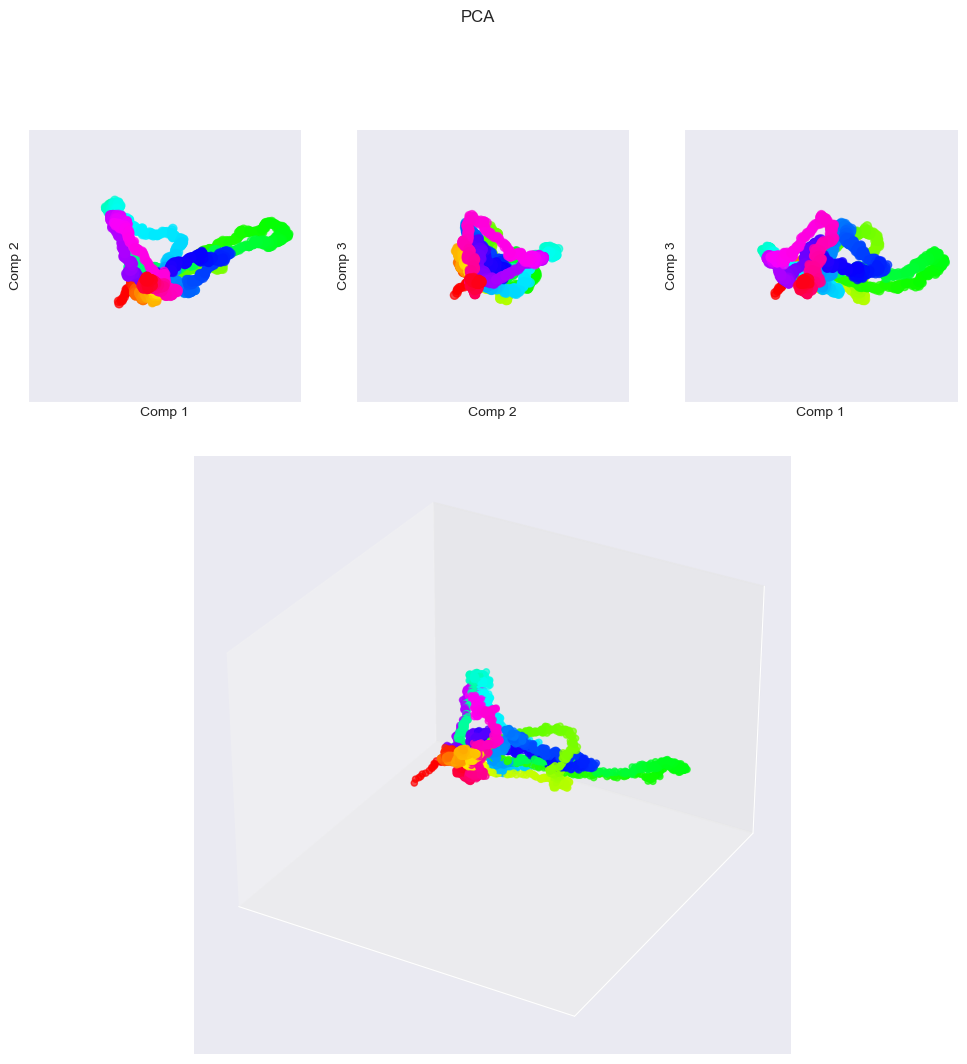

In [32]:
### Plot embedding
plt.set_cmap('hsv') # circular cmap
MIN = -AXIS_LIM
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('PCA')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = time_axis#[::down][::ds_plt]
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()


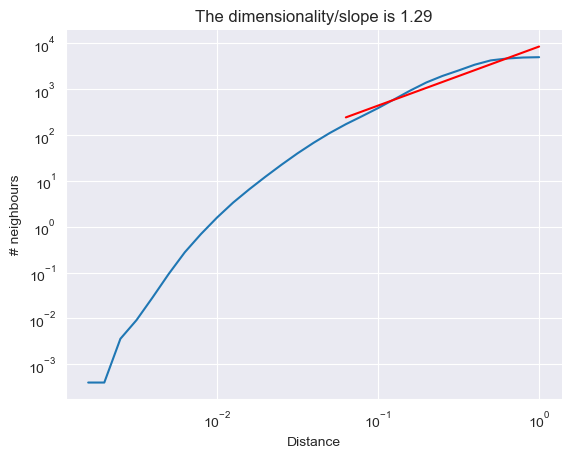

In [34]:
### Intrinsic dimensionality
EMBD = 'PCA'
nstep = 30
Nneigh, radii, p = nml.intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean',
                                            fit='std', thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [35]:
### OLE  decoding
EMBD = 'PCA'
N = DIMS
cv = 10 # no cv folds
Y = time_axis #phi[::down].flatten() # angular position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = nml.OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = nml.LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

In [36]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain original high-dim activity and its embedding
    Y = Y_sc[::2,:dim+1]
    X_ = X[::2].copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = nml.new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
#         s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
#         s1 = np.mean((X_[test_idx] - X_rec)**2)
#         s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
#         var_expl_embd[EMBD][dim,c] = 1 - s0/s2
#         var_expl[EMBD][dim,c] = 1 - s1/s2
#         rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


Text(0.5, 1.0, 'Reconstructed')

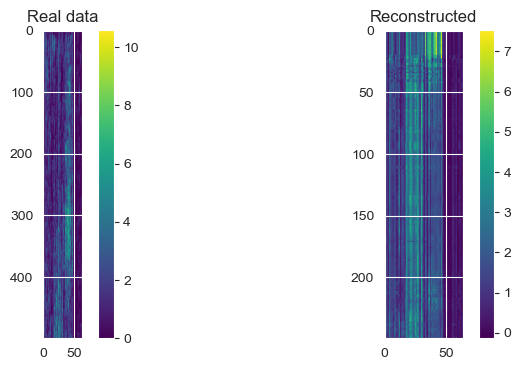

In [37]:
plt.figure(figsize=(9,4));
plt.subplot(121)
plt.imshow(X_[:500],cmap='viridis'); plt.colorbar()
plt.title('Real data')
plt.subplot(122)
plt.imshow(X_rec[:500],cmap='viridis'); plt.colorbar()
plt.title('Reconstructed')

In [39]:
rec_corr['PCA'].mean()

0.7947564235823257

#### 2. Multi-Dimensional Scaling (MDS)

Like PCA, this is a linear mapping to find a (linear) projection of the high-dimensional data onto a low-dimensional sub-space.

In [40]:
### Fit embedding
x_embd,eig_mds_dff = nml.cmdscale(D)
x_embd = x_embd / np.max(x_embd)

<Figure size 640x480 with 0 Axes>

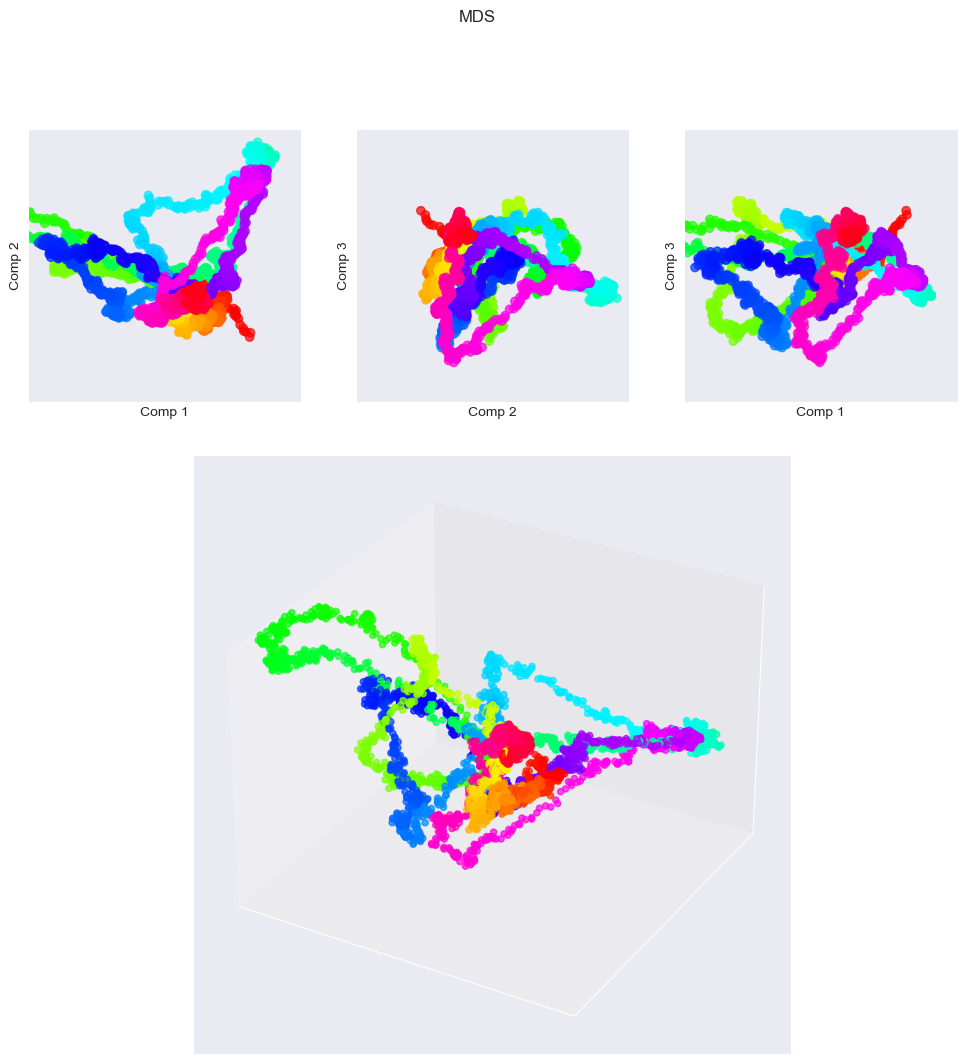

In [41]:
### Plot embedding
plt.set_cmap('hsv') # circular cmap
MIN = -AXIS_LIM
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('MDS')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = time_axis # phi[::down][::ds_plt]
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()


Text(0.5, 0, 'Number of dimensions')

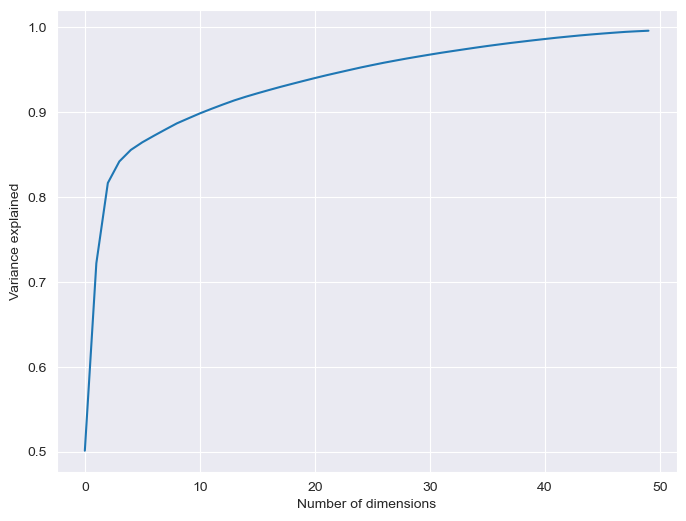

In [42]:
evals_mds_ = eig_mds_dff[eig_mds_dff>0] / np.sum(eig_mds_dff[eig_mds_dff>0])
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(evals_mds_)[:50])
plt.ylabel('Variance explained')
plt.xlabel('Number of dimensions')

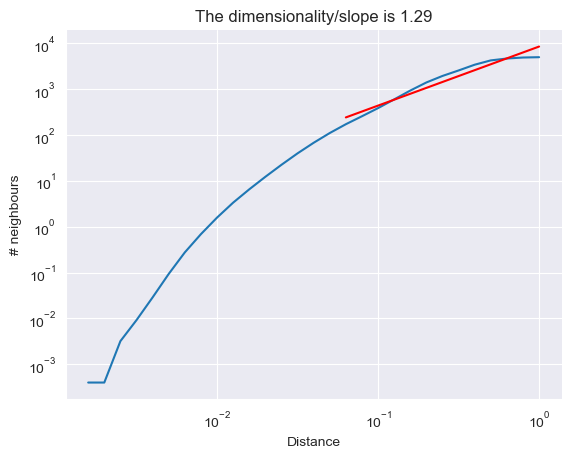

In [43]:
### Dimensionality
EMBD = 'MDS'
nstep = 30
Nneigh, radii, p = nml.intrinsic_dimensionality(x_embd[:,:DIMS], nstep=nstep, metric='euclidean',
                                                fit='std', thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [44]:
### OLE  decoding
EMBD = 'MDS'
N = DIMS
cv = 10
Y = time_axis # phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = nml.OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = nml.LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

In [45]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding

    Y = Y_sc[:,:dim+1]
    X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = nml.new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle,
                                Y[test_idx,:].T, LAMBDA)
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


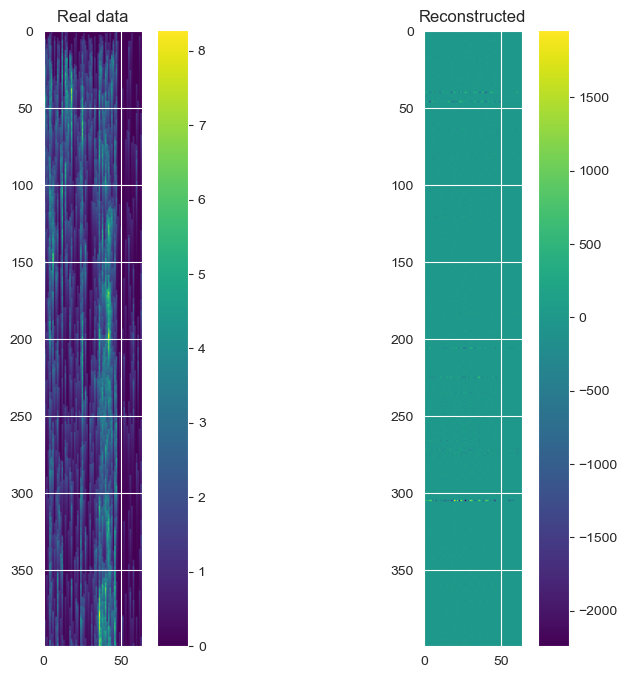

In [46]:
# Visualise a reconstruction example
plt.figure(figsize=(9,8));
plt.subplot(121);
plt.imshow(X_[:400],cmap='viridis'); plt.colorbar()
plt.title('Real data')
plt.subplot(122)
plt.imshow(X_rec[:400],cmap='viridis'); plt.colorbar()
plt.title('Reconstructed');

In [48]:
rec_corr['MDS'].mean()

0.1483383460646903